# load 库

In [2]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image

In [3]:
torch.cuda.set_device(3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data

## load CIFAR10

In [4]:
from random import shuffle
batch_size = 128
trans = transforms.Compose([
    transforms.ToTensor(), # numpy -> Tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # 归一化 ，范围[-1,1]
])
cifar10_train = dsets.CIFAR10(root='./data',train=True, download=True, transform = trans)
cifar10_test = dsets.CIFAR10(root='./data',train=False, download=True, transform = trans)
train_loader = torch.utils.data.DataLoader(dataset=cifar10_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=cifar10_test, batch_size=batch_size,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


tensor(6)
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F6C0CCC12E8>


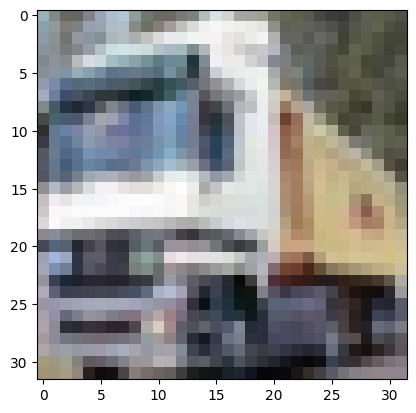

In [4]:
for batch_images,batch_labels in train_loader:
    break
print(batch_labels[0])
image = batch_images[1]
toPIL = transforms.ToPILImage()
pic = toPIL(image)
print(pic)
plt.imshow(pic)
plt.show()

## load Imagenet

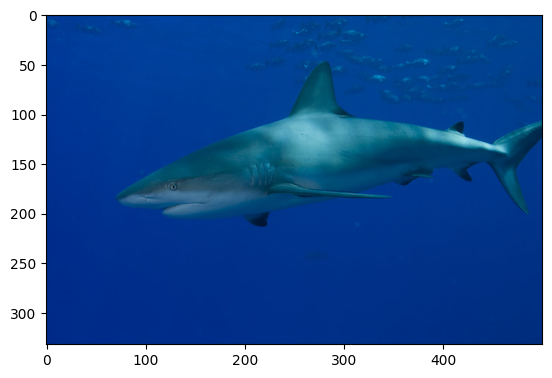

torch.Size([3, 332, 500])


In [5]:
from PIL import Image
import matplotlib.pyplot as plt

path ='./data/ImageNet2012/train/n01491361/n01491361_1000.JPEG'
img=Image.open(path)
plt.imshow(img)
plt.show()
trans =transforms.ToTensor()
img = trans(img)
print(img.size())

In [6]:
#val set
from scipy import io
import os
import shutil

def move_valimg(val_dir='./data/ImageNet2012/val/', devkit_dir='./data/ImageNet2012/val/ILSVRC2012_devkit_t12/'):
    """
    move valimg to correspongding folders.
    val_id(start from 1) -> ILSVRC_ID(start from 1) -> WIND
    organize like:
    /val
       /n01440764
           images
       /n01443537
           images
        .....
    """
    # load synset, val ground truth and val images list
    synset = io.loadmat(os.path.join(devkit_dir, 'data', 'meta.mat'))
    
    ground_truth = open(os.path.join(devkit_dir, 'data', 'ILSVRC2012_validation_ground_truth.txt'))
    lines = ground_truth.readlines()
    labels = [int(line[:-1]) for line in lines]
    
    root, _, filenames = next(os.walk(val_dir))
    for filename in filenames:
        # val image name -> ILSVRC ID -> WIND
        val_id = int(filename.split('.')[0].split('_')[-1])
        ILSVRC_ID = labels[val_id-1]
        WIND = synset['synsets'][ILSVRC_ID-1][0][1][0]
        print("val_id:%d, ILSVRC_ID:%d, WIND:%s" % (val_id, ILSVRC_ID, WIND))

        # move val images
        output_dir = os.path.join(root, WIND)
        if os.path.isdir(output_dir):
            pass
        else:
            os.mkdir(output_dir)
        shutil.move(os.path.join(root, filename), os.path.join(output_dir, filename))

if __name__ == '__main__':
    move_valimg()


## Load MNIST

In [7]:
mnist_train = dsets.MNIST(root='./data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='./data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
batch_size=128
mnist_train_loader = torch.utils.data.DataLoader(mnist_train,batch_size,shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test,batch_size,shuffle=False)

# define model

## 1.CNN

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 3*32*32   --->   10*14*14
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        #10*14*14   --> 20*5*5
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=10,out_channels=20,kernel_size=5),
            torch.nn.BatchNorm2d(20),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)

        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=20, out_channels=30,kernel_size=3),
            torch.nn.BatchNorm2d(30),
            torch.nn.ReLU(),
        )
        self.linear = torch.nn.Linear(30*3*3, 10)
        self.Dropout = torch.nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Dropout(x)
        x = self.conv3(x)
        x = x.view(-1,30*3*3)
        x = self.linear(x)

        return x

In [87]:
seed = 0
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子
modelCNN = CNN()
modelCNN =modelCNN.to(device)

In [88]:
optimizer = optim.SGD(params=modelCNN.parameters(), lr=0.001, momentum=0.9)
loss = torch.nn.CrossEntropyLoss()

### train cnnmodel

In [89]:
def get_num_correct(preds, labels):
    preds = preds.to(device)
    labels = labels.to(device)
    return preds.argmax(dim=1).eq(labels).sum().item()

In [93]:
epoch = 100
total_batch = len(cifar10_train)
minacc = 0.5
maxloss = 1000
modelCNN.train()
for train_epoch in range(epoch):
    total_correct=0
    Loss = 0
    for i,(inputs,labels) in enumerate(train_loader):

        inputs, labels = inputs.to(device), labels.to(device)
        y = modelCNN(inputs)
        cost = loss(y, labels)
        Loss += cost.item()
        total_correct += get_num_correct(y,labels)
        #误差反传
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    epoch_loss = Loss/(len(train_loader.dataset))
    acc = total_correct/total_batch
    print("Epoch {}     Loss = {}".format(train_epoch + 1, epoch_loss))
    print(total_correct,acc)
    if acc> minacc and epoch_loss<maxloss:
        print("savemodel with acc = {} and Loss = {}".format(acc,epoch_loss))
        minacc=acc
        maxloss=epoch_loss
        torch.save(modelCNN.state_dict(),'cnn_parameter_cifar10(bs128+dropout+transform).pkl')

print("final_model with acc = {} and Loss = {}".format(minacc,maxloss))  

Epoch 1     Loss = 0.010907164652347565
24697 0.49394
Epoch 2     Loss = 0.010535246834754944
25754 0.51508
savemodel with acc = 0.51508 and Loss = 0.010535246834754944
Epoch 3     Loss = 0.010269585797786713
26417 0.52834
savemodel with acc = 0.52834 and Loss = 0.010269585797786713
Epoch 4     Loss = 0.010033964498043061
26955 0.5391
savemodel with acc = 0.5391 and Loss = 0.010033964498043061
Epoch 5     Loss = 0.009817217092514038
27543 0.55086
savemodel with acc = 0.55086 and Loss = 0.009817217092514038
Epoch 6     Loss = 0.009652521008253097
27850 0.557
savemodel with acc = 0.557 and Loss = 0.009652521008253097
Epoch 7     Loss = 0.009507056806087493
28233 0.56466
savemodel with acc = 0.56466 and Loss = 0.009507056806087493
Epoch 8     Loss = 0.009356793719530106
28653 0.57306
savemodel with acc = 0.57306 and Loss = 0.009356793719530106
Epoch 9     Loss = 0.009287609084844588
28813 0.57626
savemodel with acc = 0.57626 and Loss = 0.009287609084844588
Epoch 10     Loss = 0.0091387378

In [89]:
#0.68854 : cnn_parameter_cifar10(bs128+dropout+transform).pkl test:65.63%

### test cnnmodel

In [6]:
#load 目标模型
path = 'cnn_parameter_cifar10(bs128+dropout+transform).pkl'
modelCNN = CNN()
modelCNN = modelCNN.to(device)
modelCNN.load_state_dict(torch.load(path))
modelCNN.eval()
correct=0
total=0
for i, (samples,labels) in enumerate(test_loader):
    samples = samples.to(device)
    labels = labels.to(device)
    outputs = modelCNN(samples)
    _ , predicted = torch.max(outputs.data,1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum()

print('accuracy: %.2f%%' % (100*float(correct/total)))
    

accuracy: 65.63%


## 2.Resnet

In [91]:
import timm

In [15]:
Resnet=timm.create_model('resnet50', pretrained=True)
Resnet = Resnet.to(device)

NameError: name 'timm' is not defined

In [16]:
def mymodel(model,img):
    img = img.to(device)
    with torch.no_grad():
        out = model(img)
    probabilities = torch.nn.functional.softmax(out[0], dim=0)
    _ , predicted = torch.max(out.data,1)
    return int(predicted)

In [17]:
#load val data
from fileinput import filename
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

Resnet.eval()

config = resolve_data_config({}, model=Resnet)
transform = create_transform(**config)

image_path='./data/ImageNet2012/val/'
i = 0
correct = 0
#提取文件夹中子文件夹明，去掉非图片文件夹
file_list = os.listdir(image_path)
file_list.remove('ILSVRC2012_devkit_t12')

#文件夹名与图片类别对应
index_namefile = open('./classindex.txt')
index_name=[]
for data in index_namefile.readlines():
    data = data.split( )
    index_name.append(data[1])

#读图片输入到模型中
for path in file_list:
    index = index_name.index(path)
    file_path = os.path.join(image_path,path)
    I_path = os.listdir(file_path)
    for image in I_path:
        image = os.path.join(file_path, image)
        img = Image.open(image).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)
        pre = mymodel(Resnet,img_tensor)
        if pre == index:
            correct = correct+1
        i=i+1
    
print('acc:',correct/i)


ModuleNotFoundError: No module named 'timm'

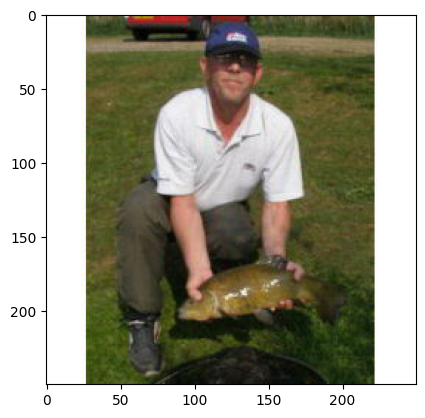

NameError: name 'Resnet' is not defined

In [18]:
image_path='./data/ImageNet2012/train/n01440764/n01440764_10026.JPEG'
image = Image.open(image_path)
plt.imshow(image)
plt.show()
trans = transforms.ToTensor()
image = trans(image)
image=image.unsqueeze(0)
y=Resnet(image)
probabilities = torch.nn.functional.softmax(y[0], dim=0)
_ , predicted = torch.max(y.data,1)
print(predicted)

In [19]:
#输出分类中最可能的前五类
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

NameError: name 'probabilities' is not defined

# Adv sample

## FSGM

In [20]:
def myFGSM(image,label,eps=1/255):
    image = image.clone().detach()
    label = label.clone().detach()
    
    loss = nn.CrossEntropyLoss()

    image.requires_grad = True
    output = modelCNN(image) #modelCNN
    cost = -1*loss(output,label)
        
    grad = torch.autograd.grad(cost,image,retain_graph=False,create_graph=False)[0]
    adv_images = image - eps*grad.sign()
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    return adv_images

In [21]:
modelCNN.eval()
correct=0
total=0
for samples,labels in test_loader:
    samples = samples.to(device)
    labels = labels.to(device)
    advsampls=myFGSM(samples,labels,eps=1/255)
    outputs = modelCNN(advsampls)
    _ , predicted = torch.max(outputs.data,1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum()

print('accuracy: %.2f%%' % (100*float(correct/total)))

RuntimeError: shape '[128, -1]' is invalid for input of size 270000

## PGD

In [22]:
def myPGD(image,label,eps=1/255,alpha=1/255,steps=10,random_start=False):
    images = image.clone().detach()
    labels = label.clone().detach()
        
    loss = nn.CrossEntropyLoss()
    adv_images = images.clone().detach()

    if random_start:
            # Starting at a uniformly random point
        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-eps, eps)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for i in range(steps):
        adv_images.requires_grad = True
        outputs = modelCNN(adv_images)
        cost = -1*loss(outputs, labels)

        grad = torch.autograd.grad(cost, adv_images,retain_graph=False, create_graph=False)[0]
        adv_images = adv_images.detach() - alpha*grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [23]:
modelCNN.eval()
correct=0
total=0
for samples,labels in test_loader:
    samples = samples.to(device)
    labels = labels.to(device)
    advsampls=myPGD(samples,labels)
    outputs = modelCNN(advsampls)
    _ , predicted = torch.max(outputs.data,1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum()

print('accuracy: %.2f%%' % (100*float(correct/total)))

RuntimeError: shape '[128, -1]' is invalid for input of size 270000

## MIM

In [24]:
def myMIM(image,label,eps=1/255,decay=1.0,steps=5):
    alpha = eps/steps

    image = image.clone().detach()
    label = label.clone().detach()
    
    loss = nn.CrossEntropyLoss()
    momentum = torch.zeros_like(image).detach()
    adv_images = image.clone().detach()
    
    for i in range(steps):
        adv_images.requires_grad = True
        output = modelCNN(adv_images) #modelCNN
        cost = -1*loss(output,label)
        grad = torch.autograd.grad(cost,adv_images,retain_graph=False,create_graph=False)[0]
        
        grad_norm = torch.norm(nn.Flatten()(grad),p=1,dim=1)
        grad = grad / grad_norm.view([-1]+[1]*(len(grad.shape)-1))
        grad = grad + momentum*decay
        momentum = grad

        adv_images = adv_images.detach() - alpha*grad.sign()
        delta = torch.clamp(adv_images - image, min = -eps, max = eps)
        adv_images = torch.clamp(image+delta,min=0, max=1).detach()
        
    return adv_images

In [25]:
modelCNN.eval()
correct=0
total=0
for samples,labels in test_loader:
    samples = samples.to(device)
    labels = labels.to(device)
    advsampls=myMIM(samples,labels,eps=1/255)
    outputs = modelCNN(advsampls)
    _ , predicted = torch.max(outputs.data,1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum()

print('accuracy: %.2f%%' % (100*float(correct/total)))

RuntimeError: shape '[128, -1]' is invalid for input of size 270000

## BIM

In [26]:
def myBIM(image,label,eps=1/255,steps=5): 
    if steps == 0:
        steps = int(min(eps*255 + 4, 1.25*eps*255))
    else:
        steps = steps
    alpha=eps/steps
    image = image.clone().detach()
    label = label.clone().detach()
    loss = nn.CrossEntropyLoss()
    ori_images = image.clone().detach()
    
    for i in range(steps):
        image.requires_grad = True
        output = modelCNN(image) #modelCNN
        cost = -1*loss(output,label)
        grad = torch.autograd.grad(cost,image,retain_graph=False,create_graph=False)[0]
        adv_images = image - alpha*grad.sign()
        a = torch.clamp(ori_images - eps, min=0)
        b = (adv_images >= a).float()*adv_images + (adv_images < a).float()*a 
        c = (b > ori_images+eps).float()*(ori_images+eps) + (b <= ori_images + eps).float()*b 
        image = torch.clamp(c,  max=1).detach()
            
    return image

In [27]:
modelCNN.eval()
correct=0
total=0
for samples,labels in test_loader:
    samples = samples.to(device)
    labels = labels.to(device)
    advsampls=myBIM(samples,labels)
    outputs = modelCNN(advsampls)
    _ , predicted = torch.max(outputs.data,1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum()

print('accuracy: %.2f%%' % (100*float(correct/total)))

RuntimeError: shape '[128, -1]' is invalid for input of size 270000

# myadvsample generate

In [7]:
from functools import partial

### patch and flatten

In [8]:
from einops import rearrange
from einops.layers.torch import Rearrange,Reduce
#输入图片patch(CNN) and flatten
#图片为cifar10数据集3*32*32
class PatchEmbedding(nn.Module):
    def __init__(self,img_size=32,patch_size=16,in_c=3,embed_dim=16*16*3):
        super().__init__()
        
        img_size = (img_size,img_size) 
        #patch_size = (patch_size,patch_size) 
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0]//patch_size,img_size[1]//patch_size) 
        self.patches = self.grid_size[0]*self.grid_size[1]

        #图片为3*32*32，划分为16*16*3的小块，共self.patches=4
        #利用einops对图片patch并重新排列
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (c p1 p2)', p1 = self.patch_size, p2 = self.patch_size),
            nn.Linear(embed_dim, embed_dim),
        )
        #self.proj = nn.Conv2d(in_c,embed_dim,kernel_size=patch_size,stride=patch_size)

    def forward(self,x):
        B,C,H,W = x.shape
    
        assert H == self.img_size[0] and W == self.img_size[1],\
            f"Input image size ({H}*{W}) doesn't match mode ({self.img_size[0]}*{self.img_size[1]})."
    
        x = self.to_patch_embedding(x)
        return x


### drop_path

In [9]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1) #work with diff dim tensor, not just 2D convNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

In [10]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

### MultiHead-self-Attention

In [11]:
class Attention(nn.Module):
    def __init__(self,dim,num_heads,qkv_bias=False,qk_scale=None,attn_drop_ratio=0.,\
        proj_drop_ratio=0.2,window_size=2):
        # dim:输入token的dim
        # num_heads:头数
        # qkv_bias：生成qkv的bias
        # qk_scale: None时使用：根号dk分之一
        super(Attention,self).__init__()
        self.num_heads = num_heads
        head_dim = dim//num_heads #每个头分到的qkv的个数
        self.scale = qk_scale or head_dim**(-0.5)
        self.qkv = nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)
        self.window_size = window_size

        if self.window_size != 0:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

            # get pair-wise relative position index for each token inside the window
            coords_h = torch.arange(window_size)
            coords_w = torch.arange(window_size)
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2 ；contiguous()函数的作用：把tensor变成在内存中连续分布的形式。
            relative_coords[:, :, 0] += window_size - 1  # shift to start from 0
            relative_coords[:, :, 1] += window_size - 1
            relative_coords[:, :, 0] *= 2 * window_size - 1
            relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            self.register_buffer("relative_position_index", relative_position_index)

            nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self,x):
        B,N,C=x.shape
        #B:batchsize,N=1+num_patches(1:class_token),C:embed_dim

        qkv = self.qkv(x)
        qkv = qkv.reshape(B,N,3,self.num_heads,C//self.num_heads).permute(2,0,3,1,4)
        q,k,v = qkv[0],qkv[1],qkv[2]

        attn = (q @ k.transpose(-2,-1))*self.scale
        if self.window_size != 0:
            relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1).clone()].view(
                self.window_size * self.window_size, self.window_size * self.window_size, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)
        attn = attn.softmax(dim=-1) #最后一维
        attn_map = attn
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x,attn_map

### MLP module

In [12]:
class MLP(nn.Module):
    def __init__(self,in_feature,hidde_feature=None,out_feature=None,act_layer=nn.GELU,drop=0.2):
        super().__init__()

        out_feature = out_feature or in_feature
        hidde_feature = hidde_feature or in_feature

        self.fc1 = nn.Linear(in_feature,hidde_feature)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidde_feature,out_feature)
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Encoder block(Attn + MLP)

In [13]:
class En_Block(nn.Module):
    def __init__(self,dim,num_heads,mlp_ratio=4.,qkv_bias=False,qk_scale=None,attn_drop_ratio=0.,\
        proj_drop_ratio=0.2,act_layer=nn.GELU,drop_path_ratio=0.,norm_layer=nn.LayerNorm,window_size=2):
        # dim:输入token的dim
        # num_heads:头数
        # mlp_ratio: mlp第一个FC节点数是输入的4倍
        # qkv_bias：生成qkv的bias
        # qk_scale: None时使用：根号dk分之一
        # act_layer: 激活函数
        # norm_layer: 归一化函数
        super(En_Block,self).__init__()
        
        self.norm = norm_layer(dim)
        self.attn = Attention(dim,num_heads=num_heads,qkv_bias=qkv_bias,qk_scale=qk_scale,\
            attn_drop_ratio=attn_drop_ratio,proj_drop_ratio=proj_drop_ratio,window_size=window_size)
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio>0. else nn.Identity()
        mlp_hidden_dim = int(dim*mlp_ratio)
        self.mlp = MLP(in_feature=dim, hidde_feature=mlp_hidden_dim,act_layer=act_layer,\
            drop=proj_drop_ratio)
        
    def forward(self,x): #残差结构
        x1= x
        x = self.norm(x)
        x,attnmap = self.attn(x)
        x = self.drop_path(x)
        x = x1+x
        y=x

        x2= x
        x = self.norm(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x2+x

        global attn
        attn = attnmap
        return x

### patchsplicing(图片拼接)

In [14]:
class PatchSplicing(nn.Module):
    def __init__(self,img_size=32,patch_size=16,in_c=3):
        super(PatchSplicing,self).__init__()
        
        self.patch = img_size//patch_size
        self.c = in_c
        self.patch_size = patch_size
        self.to_patch_splicing = nn.Sequential(
            Rearrange('b (h w) (c p1 p2) -> b  c (h p1) (w p2)', h= self.patch, w =self.patch, c=self.c,
            p1 = self.patch_size, p2 = self.patch_size),
            nn.Linear(img_size, img_size),
        )

    def forward(self,x):
        x = self.to_patch_splicing(x)
        return x

### adv tranformer module

In [15]:
def _init_AT_weight(m):
    if isinstance(m,nn.Linear):
        nn.init.trunc_normal_(m.weight,std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Conv2d):
        nn.init.kaiming_normal_(m.weight,mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m,nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)

In [26]:
class adv_transformer(nn.Module):
    def __init__(self,img_size=32,patch_size=16,in_c=3,num_classes=10,#cifar10
        embed_dim=768,depth=2,num_heads=1,mlp_ratio=2.,
        qkv_bias=True,qk_scale=None,
        proj_drop_ratio=0.5,attn_drop_ratio=0.5,drop_path_ratio=0.,
        embed_layer=PatchEmbedding,norm_layer=None,act_layer=None, patch_splicing_layer=PatchSplicing):
        super(adv_transformer,self).__init__()
        
        self.num_classes = num_classes
        self.num_feature = self.embed_dim = embed_dim
        norm_layer = norm_layer or partial(nn.LayerNorm,eps=1e-6) # partial默认固定函数的某些参数
        act_layer = act_layer or nn.GELU

        # patch 
        self.patch = embed_layer(img_size=img_size,patch_size=patch_size,in_c=in_c,embed_dim=embed_dim)
        num_patches = self.patch.patches
        window_size = int(num_patches**0.5)
        #position embed and init
        self.pos_embed = nn.Parameter(torch.zeros(1,num_patches,embed_dim))
        nn.init.trunc_normal_(self.pos_embed,std=0.02)
        #dropout
        self.pos_drop = nn.Dropout(p=proj_drop_ratio)
        #depth次encoder block-->生成长度为depth的drop_ratio,取值区间为(0,drop_path_ratio)
        dpr = [x.item() for x in torch.linspace(0,drop_path_ratio,depth)]
        #depth个encoder block
        self.blocks = nn.Sequential(*[
            En_Block(dim=embed_dim,num_heads=num_heads,mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,qk_scale=qk_scale,
            attn_drop_ratio=attn_drop_ratio,proj_drop_ratio=proj_drop_ratio,
            act_layer=nn.GELU,drop_path_ratio=dpr[i],norm_layer=nn.LayerNorm,window_size=window_size)
            for i in range(depth)
        ])
        #图片重新拼接
        self.patchsplicing = patch_splicing_layer(img_size=img_size,patch_size=patch_size,in_c=in_c)
        #权重初始化
        self.apply(_init_AT_weight)
        
    def forward(self,x):
        #patch
        x = self.patch(x)
        x3=x
        #pos
        x = x+self.pos_embed
        x2=x
        #tran encoder
        x = self.blocks(x)
        x1 = x
        #splicing
        x = self.patchsplicing(x)
        
        return x

## train muti-attention

In [23]:
seed = 0
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [22]:
#load 目标模型
path = './cnn_parameter_cifar10(bs128+dropout+transform).pkl'
modelCNN = CNN()
modelCNN = modelCNN.to(device)
modelCNN.load_state_dict(torch.load(path))

<All keys matched successfully>

In [21]:
def get_num_correct(y1, y2):
    y1 = y1.to(device)
    y2 = y2.to(device)
    return y1.argmax(dim=1).eq(y2).sum().item()

In [20]:
class LinearLrDecay(object):
    def __init__(self, optimizer, start_lr, end_lr, decay_start_step, decay_end_step,warmup_step=100):

        assert start_lr > end_lr
        self.optimizer = optimizer
        self.delta = (start_lr - end_lr) / (decay_end_step - decay_start_step)
        self.decay_start_step = decay_start_step
        self.decay_end_step = decay_end_step
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.warmup_step = warmup_step

    # def step(self, current_step):
    #     if current_step <= self.decay_start_step:
    #         lr = self.start_lr
    #     elif current_step >= self.decay_end_step:
    #         lr = self.end_lr
    #     elif current_step <self.warmup_step:
    #         warmup_precent_done = current_step / self.warmup_step
    #         lr = self.start_lr * warmup_precent_done
    #         for param_group in self.optimizer.param_groups:
    #             param_group['lr'] = lr
    #     else:
    #         #lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
    #         lr = self.start_lr ** 1.001
    #         for param_group in self.optimizer.param_groups:
    #             param_group['lr'] = lr
    #     return lr
    
    def step(self, current_step):
        if current_step <= self.decay_start_step:
            lr = self.start_lr
        elif current_step >= self.decay_end_step:
            lr = self.end_lr
        else:
            lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        return lr

In [19]:
#loss 函数
def Lossfunc(lossname,y,label,img,transimg,batch_size=1000):
    if lossname == "CrossEntropyLoss":
        loss = nn.CrossEntropyLoss()(y,label)
    elif lossname == "lsgan":
        real_label = torch.full((y.shape[0],y.shape[1]), 1., dtype=torch.float).to(device)
        loss = nn.MSELoss()(y, real_label)
    elif lossname == 'wgangp-mode':
        fake_image1, fake_image2 = transimg[:batch_size//2], transimg[batch_size//2:]
        z_1, z_2 = img[:batch_size//2], img[batch_size//2:]
        lz = torch.mean(torch.abs(fake_image2 - fake_image1)) / torch.mean(torch.abs(z_2 - z_1))
        eps = 1 * 1e-5
        loss_lz = 1 / (lz + eps)
        #loss = -torch.mean(y) + loss_lz
        loss = nn.CrossEntropyLoss()(y,label)+loss_lz
    else:
        loss = -torch.mean(y)
    return loss

In [27]:
#train
from math import inf
from adamw import AdamW
from torch.utils.data import random_split
#from DiffAugment_pytorch import DiffAugment

device = torch.device(device)
print("Device:",device)

advtrans = adv_transformer(proj_drop_ratio=0.5,attn_drop_ratio=0.5,drop_path_ratio=0.)
advtrans = advtrans.to(device)

#policy = 'color,translation,cutout'
lr =0.0001
max_epoch = 500
optimizer = optim.Adam(filter(lambda p: p.requires_grad, advtrans.parameters()),lr,(0,0.99))
#optimizer = AdamW(filter(lambda p: p.requires_grad, advtrans.parameters()),lr=lr)
#CrossEntropyLoss lsgan wgangp-mode
lossfun_name = "wgangp-mode"
scheduler = LinearLrDecay(optimizer, lr, 0.0, 0, 5000*4)
best_valacc = 0
vallost = inf
earlyflag=0

modelCNN.eval()
#10折交叉验证训练(划分训练集)
for i in range(5):
    train_dataset, val_dataset = random_split(
        dataset=cifar10_train,
        lengths=[int(len(cifar10_train)*0.8), int(len(cifar10_train)*0.2)],
        generator=torch.Generator().manual_seed(i)
        )
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False)
    advtrans.train()
    for train_epoch in range(max_epoch):
        total_correct=0
        valcorrect=0
        TLoss = 0
        VLoss = 0
        for i,(inputs,labels) in enumerate(train_loader):
            labels = labels.to(device)
            inputs = inputs.to(device)
            x1 = advtrans(inputs)
            y2 = modelCNN(x1) 
            bs = labels.shape[0]
            traincost = Lossfunc(lossfun_name,y=y2,label=labels,img=inputs,transimg=x1,batch_size=bs)
            #误差反向传播
            for p in modelCNN.parameters():
                p.requires_grad_(False)     
            torch.nn.utils.clip_grad_norm_(advtrans.parameters(), 5.)
            optimizer.zero_grad()
            traincost.backward()
            optimizer.step()
            TLoss += traincost.item()
            total_correct += get_num_correct(y2,labels)
        
        if scheduler:
            scheduler.step(train_epoch)
                
        acc=total_correct/(len(train_loader.dataset))
        epoch_tloss = TLoss/(len(train_loader.dataset))
        print("Epoch {}     Loss = {}     lr={}".format(train_epoch + 1, epoch_tloss,optimizer.state_dict()['param_groups'][0]['lr']))
        print("     total_correct on train={}       acc={}".format(total_correct,acc))
            
        #val_set
        advtrans.eval()
        with torch.no_grad():
            for val_data,val_label in val_loader:
                val_data = val_data.to(device)
                val_label = val_label.to(device)
                x1 = advtrans(val_data)
                y2 = modelCNN(x1)
                bs = val_label.shape[0]
                valcost = Lossfunc(lossfun_name,y=y2,label=val_label,img=val_data,transimg=x1,batch_size=bs)
                VLoss += valcost.item()
                _ , predicted = torch.max(y2.data,1)    
                valcorrect = valcorrect + (predicted == val_label).sum()
            
        val_acc = valcorrect/(len(val_loader.dataset))
        epoch_vloss = VLoss/(len(val_loader.dataset))
        print("     valacc={}   val_loss={}".format(val_acc,epoch_vloss))
        if epoch_vloss < vallost:
            print("     val loss has decreased from {} -->{}".format(vallost,epoch_vloss))
            vallost = epoch_vloss
            print("     savemodel with acc = {} and Loss = {}".format(acc,epoch_tloss))
            bestacc = acc
            bestloss = epoch_tloss
            torch.save(advtrans.state_dict(),'advtrans_parameter_cifar10.pkl')
        else:
            earlyflag += 1
        if earlyflag==10:
            break

print("final_model with acc = {} and Loss = {}".format(bestacc,bestloss))  

Device: cuda
Epoch 1     Loss = 0.2487395558834076     lr=0.0001
     total_correct on train=4408       acc=0.1102
     valacc=0.10300000011920929   val_loss=0.28278056030273435
     val loss has decreased from inf -->0.28278056030273435
     savemodel with acc = 0.1102 and Loss = 0.2487395558834076
Epoch 2     Loss = 0.03829408133625984     lr=9.999500000000001e-05
     total_correct on train=7960       acc=0.199
     valacc=0.21439999341964722   val_loss=0.02651101746559143
     val loss has decreased from 0.28278056030273435 -->0.02651101746559143
     savemodel with acc = 0.199 and Loss = 0.03829408133625984
Epoch 3     Loss = 0.0229336532831192     lr=9.999000000000001e-05
     total_correct on train=10018       acc=0.25045
     valacc=0.260699987411499   val_loss=0.02173839008808136
     val loss has decreased from 0.02651101746559143 -->0.02173839008808136
     savemodel with acc = 0.25045 and Loss = 0.0229336532831192
Epoch 4     Loss = 0.019480660939216615     lr=9.9985e-05
  

KeyboardInterrupt: 

In [1]:
print("final_model with acc = {} and Loss = {}".format(bestacc,bestloss)) 

NameError: name 'minacc' is not defined

## test advmodel

In [ ]:
#'cnn_parameter_cifar10(bs128+dropout+transform).pkl' train: test:

In [28]:
#load 目标模型
path = './cnn_parameter_cifar10(bs128+dropout+transform).pkl'
modelCNN = CNN()
modelCNN = modelCNN.to(device)
modelCNN.load_state_dict(torch.load(path))
#load attention model
path = './advtrans_parameter_cifar10.pkl' 
adv_trans = adv_transformer()
adv_trans = adv_trans.to(device)
adv_trans.load_state_dict(torch.load(path))

#test acc with no attack advtrans的拟合程度
modelCNN.eval()
adv_trans.eval()
correct1=0
correct2=0
total=0
total_batch = len(cifar10_test)

for i, (samples,labels) in enumerate(test_loader):
    samples = samples.to(device)
    labels = labels.to(device)
    y = modelCNN(samples)
    x = adv_trans(samples)
    outputs = modelCNN(x)
    _ , predicted1 = torch.max(outputs.data,1)
    correct1 = correct1 + (predicted1 == labels).sum()
    _, pre2 = torch.max(y.data,1)
    correct2 = correct2 + (pre2 == labels).sum()

print('trans accuracy: %.2f%%' % (100*float(correct1/total_batch)))
print('cnn accuracy: %.2f%%' % (100*float(correct2/total_batch)))

trans accuracy: 42.95%
cnn accuracy: 71.40%


### output test

In [30]:
#load 目标模型
path1 = './cnn_parameter_cifar10.pkl'
advtrans = adv_transformer()
advtrans = advtrans.to(device)
advtrans.load_state_dict(torch.load(path))
#load advtrans
path2 = './advtrans_parameter_cifar10(notrian()).pkl'
advtrans = adv_transformer()
advtrans = advtrans.to(device)
advtrans.load_state_dict(torch.load(path))

<All keys matched successfully>

In [45]:
for batch_images,batch_labels in train_loader:
    break
print(batch_labels[:10])
batch_images = batch_images.to(device)
y1 = modelCNN(batch_images)
x = advtrans(batch_images)
y2 = modelCNN(x)
print(y1.argmax(dim=1)[:10])
print(y2.argmax(dim=1)[:10])

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
tensor([3, 9, 9, 4, 1, 1, 4, 7, 8, 3], device='cuda:3')
tensor([3, 9, 9, 4, 1, 1, 4, 7, 8, 3], device='cuda:3')


tensor(9)
torch.Size([3, 32, 32])


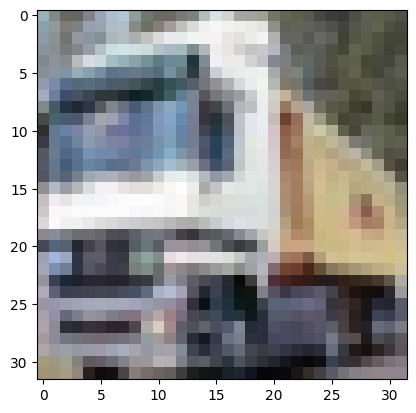

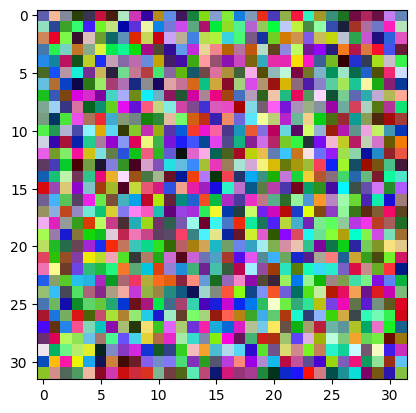

In [47]:
img1 = batch_images[1]
lable = batch_labels[1]
print(lable)
img2 = x[1]
print(img2.shape)
trans_PLI = transforms.ToPILImage()
img1 = trans_PLI(img1)
plt.imshow(img1)
plt.show()
img2 = trans_PLI(img2)
plt.imshow(img2)
plt.show()